# Implementing the NASA breakup model

The code has been entirerly taken from: https://github.com/richardklima/space_debris_removal/blob/master/breakup.py

We start with some imports:

In [1]:
import pykep as kep
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import pickle as pkl

First of all, we select from the catalogue two satellites to make them collide. In particular we will select the NOAA-7 and NOAA-12, two metereological satellites in an SSO orbit.

In [2]:
with open("../data/debris_simulation_ic.pk", "rb") as file:
    r, v, collision_radius, to_satcat_index, satcat, debris = pkl.load(file)

# reference epoch for the initial conditions
ep = kep.epoch_from_iso_string("20220301T000000").jd # Julian date corresponding to 2022-Mar-01 00:00:00

# Prepare the data in the shape expected by the simulation object.
ic_state = np.hstack([r, v, collision_radius.reshape((r.shape[0], 1))])

We extract the first satellite and set all the parameters for the first satellite, that is the NOAA-7

In [5]:
idx_NOAA7 = []
to_satcat_NOAA7 = []
collision_radius_NOAA7 = []
count = -1 # I want it to start from 0 because I need it to extract components from a vector. See later
i = 0

# extracting from satcat all the indexes of the objects called NOAA 16 DEB and append them in a vector
for deb in np.arange(len(satcat)):
    if satcat[deb]["OBJECT_NAME"] == "NOAA 7":
        idx_NOAA7.append(deb)
        count += 1
        # we retrieve the relative to_satcat index from the series of indexes we have just obtained
        while idx_NOAA7[count] != to_satcat_index[i]:
            i += 1
        to_satcat_NOAA7.append(i)
        
# proof that we are using the right indexes
for j in to_satcat_NOAA7:
    print(satcat[to_satcat_index[j]]["OBJECT_NAME"])
    print("altitude [m]: ", np.linalg.norm((ic_state[to_satcat_NOAA7, 0], ic_state[to_satcat_NOAA7, 1], ic_state[to_satcat_NOAA7, 2])) - kep.EARTH_RADIUS)

# we augment the first object of the debris catalogue, because for the model we need a pykep planet object with the mass, the velocity and the radius
debris[0].mass = 740 # [kg]
debris[0]._v = np.array((ic_state[to_satcat_NOAA7, 3][0], ic_state[to_satcat_NOAA7, 4][0], ic_state[to_satcat_NOAA7, 5][0])) # [m/s]
debris[0].radius = ic_state[to_satcat_NOAA7, 6][0] # [m]


NOAA 7
altitude [m]:  843458.9941562442


We then extract the second satellite, the NOAA-12

In [7]:
idx_NOAA12 = []
to_satcat_NOAA12 = []
collision_radius_NOAA12 = []
count = -1 # I want it to start from 0 because I need it to extract components from a vector. See later
i = 0

# extracting from satcat all the indexes of the objects called NOAA 16 DEB and append them in a vector
for deb in np.arange(len(satcat)):
    if satcat[deb]["OBJECT_NAME"] == "NOAA 12":
        idx_NOAA12.append(deb)
        count += 1
        # we retrieve the relative to_satcat index from the series of indexes we have just obtained
        while idx_NOAA12[count] != to_satcat_index[i]:
            i += 1
        to_satcat_NOAA12.append(i)
        
# proof that we are using the right indexes
for j in to_satcat_NOAA12:
    print(satcat[to_satcat_index[j]]["OBJECT_NAME"])
    print("altitude [m]: ", np.linalg.norm((ic_state[to_satcat_NOAA12, 0], ic_state[to_satcat_NOAA12, 1], ic_state[to_satcat_NOAA12, 2])) - kep.EARTH_RADIUS)

# we augment the second object of the debris catalogue, because for the model we need a pykep planet object with the mass, the velocity and the radius
debris[1].mass = 735 # [kg]
debris[1]._v = np.array((ic_state[to_satcat_NOAA12, 3][0], ic_state[to_satcat_NOAA12, 4][0], ic_state[to_satcat_NOAA12, 5][0])) # [m/s]
debris[1].radius = ic_state[to_satcat_NOAA12, 6][0] # [kg]

NOAA 12
altitude [m]:  802707.8510853043


# We define the functions that will give us the fragments

This is the function taken from the notebook on GitHub. As my supervisor said: don't ask, do.

In [8]:
LB = 0.05
# # LB = 0.11

# def setmass(planets):    
#     for p in planets:
#         p.mass = 4./3. * math.pi * p.radius ** 3 * 92.937 * (p.radius * 2) ** -0.74 # EQ 1

def _Am(d):
    # Eq (6)
    logd = math.log10(d)
    # alpha
    if logd <= -1.95:
        alpha = 0.
    elif -1.95 < logd < 0.55:
        alpha = 0.3 + 0.4 * (logd + 1.2)
    else: # >= 0.55
        alpha = 1.
    # mu1
    if logd <= -1.1:
        mu1 = -0.6
    elif -1.1 < logd < 0:
        mu1 = -0.6 - 0.318 * (logd + 1.1)
    else: # >= 0
        mu1 = -0.95
    # sigma1
    if logd <= -1.3:
        sigma1 = 0.1
    elif -1.3 < logd < -0.3:
        sigma1 = 0.1 + 0.2 * (logd + 1.3)
    else:
        sigma1 = 0.3
    # mu2
    if logd <= -0.7:
        mu2 = -1.2
    elif -0.7 < logd < -0.1:
        mu2 = -1.2 - 1.333 * (logd + 0.7)
    else:
        mu2 = -2.0

    # sigma2
    if logd <= -0.5:
        sigma2 = 0.5
    elif -0.5 < logd < -0.3:
        sigma2 = 0.5 - (logd + 0.5)
    else:
        sigma2 = 0.3

    N1 = np.random.normal(mu1, sigma1, size=(1,1))
    N2 = np.random.normal(mu2, sigma1, size=(1,1))
    return float(10. ** (alpha * N1 + (1-alpha) * N2))
    
def _dv(Am):
    # Eq (12)
    mu = 0.9 * math.log10(Am) + 2.9
    sigma = 0.4
    N = np.random.normal(mu, sigma, size=(1,1))
    return float(10 ** N)
    
class _rv_dist(stats.rv_continuous):
    def _cdf(self, x):
        return np.where(x < LB, 0., 1 - x ** -1.71 / (LB ** -1.71))

def _checksum(line):
    res = 0
    for c in line:
        if 48 < ord(c) <= 58:  
            res += ord(c) - 48
        if c == '-':
            res += 1
    return res % 10


def _create_tles(ep, source, fragments):
    res = []

    ep_date = (datetime.datetime(2000, 1, 1) + datetime.timedelta(ep)).timetuple()
    ep_day = ep_date.tm_yday + ep_date.tm_hour/24. + ep_date.tm_min/24./60. + ep_date.tm_sec/24./60./60.
    ep_str = (str(ep_date.tm_year)[2:] + '{:12.8f}'.format(ep_day))[:14]
    # TODO change satellite ID and posibly alter international identifier?
    line1 = source.line1[:18] + ep_str + source.line1[32:-1]
    line1 += str(_checksum(line1))

    for fragment in fragments:
        r, v = source.eph(ep)
        v = np.array(v) + fragment[-3:] # add dV
        el = kep.ic2par(r, v, source.mu_central_body)
      
        try:    
            n = math.sqrt(source.mu_central_body/(4.*math.pi**2*el[0]**3)) * kep.DAY2SEC # mean motion in days 
        except:
            continue  
            # continue to next fragment 


        M = el[5] - el[1] * math.sin(el[5])
        if M < 0:
            M += 2 * math.pi

        line2 = source.line2[:8]
        line2 += '{:8.4f} '.format(el[2] * kep.RAD2DEG) # inclination (i)
        line2 += '{:8.4f} '.format(el[3] * kep.RAD2DEG) # RA (W)
        line2 += '{:.7f} '.format(el[1])[2:]            # eccentrictiy (e)
        line2 += '{:8.4f} '.format(el[4] * kep.RAD2DEG) # argument of perigee (w)
        line2 += '{:8.4f} '.format(M * kep.RAD2DEG) # mean anomaly (M)
        line2 += '{:11.8f}'.format(n)                  # mean motion

#        line2 += source.line2[63:68] #'{:5d}'.format(1) # revolutions
        line2 += '{:5d}'.format(0) # revolutions
        line2 += str(_checksum(line2))

        # sometimes there is an error 'Eccentricity out of range'
        try:
            res.append(kep.planet.tle(line1, line2))
        except:
            pass

    return res

def breakup(ep, p1, p2):
    # we assume d1 > d2
    if p1.radius < p2.radius:
        p1, p2 = p2, p1
    
    dv = np.linalg.norm(p1._v - p2._v)
    catastrophRatio = (p2.mass*dv**2)/(2*p1.mass*1000)

    # if the ratio is smaller than 40 J/g then it is non-catastrophic collision
    if catastrophRatio<40:
        M = p2.mass*dv
        Lc = np.linspace(LB, 1.)
        num = int(0.1 * M ** 0.75 * LB ** -1.71)
    else:
        # catastrophic collision
        M = p1.mass + p2.mass
        # Eq (2)
        Lc = np.linspace(LB, 1.)
        num = int(0.1 * M ** 0.75 * LB ** -1.71)

    # # Eq (2)
    # Lc = np.linspace(LB, 1.)

    # num = int(0.1 * M ** 0.75 * LB ** -1.71)


        
    ddist = _rv_dist()

    d = ddist.rvs(size=int(num+0.2*num)) # sample 20% more
    d = d[d < 2. * p1.radius][:num] # filter by max size

    print("diameter of the debris: ", d, "len", len(d))

    # plt.hist(d, bins=100, color='w')
    # plt.axvline(max(d1, d2))
    # plt.xlabel('characteristic length [m]')
    # plt.show()
    
    A = 0.556945 * d ** 2.0047077
    Am = np.array(list(map(_Am, d)))
    dv = np.array(list(map(_dv, Am)))
    m = A / Am
    print("The area distribution is: ", A, "len", len(A))
    print("The area-over-mass distribution is: ", Am, "len", len(Am))
    print("The ejection velocity distribution is: ", dv, "len", len(dv))
    print("The mass distribution is: ", m, "len", len(m))

    # create samples on unit sphere
    u = np.random.random(size=(len(dv),)) * 2. -1.
    theta = np.random.random(size=(len(dv),)) * 2. * np.pi
    v = np.sqrt(1 - u**2)
    p = np.array(zip(v * np.cos(theta), v * np.sin(theta), u))

    print(len(dv))
    # dv velocity vectors
    try:
        dv_vec = np.array(zip(p[:,0] * dv, p[:,1] * dv, p[:,2] * dv))
    except:
        # if len(p.shape) != 2:
        return
        #     p = p[None,:]
        #     dv_vec = np.array(zip(p[:,0] * dv, p[:,1] * dv, p[:,2] * dv))
        # else:
        #     pass
    
    print("the velocity vector is ", dv_vec)

#    import matplotlib.pyplot as plt
#    from mpl_toolkits.mplot3d import Axes3D
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(dv_vec[:,0], dv_vec[:,1], zs=dv_vec[:,2], s=d*100.)
#    plt.show()
#    
    #plt.plot(Lc, d.cdf(Lc), color='red')
#    plt.plot(Lc, d.pdf(Lc), color='blue')
#    plt.plot(Lc, pdf, color='green')

    
#    # Figure 5
#    fig = plt.figure()
#    ax = plt.gca()
#    ax.scatter(Am, d, marker='x', color='k')
#    ax.set_yscale('log')
#    ax.set_xscale('log')
#    plt.ylabel('A/m [m^2/kg]')
#    plt.xlabel('characteristic length [m]')
#    plt.show()
#
#
#    # Figure 6
#    plt.hist(Am, bins = 10 ** np.linspace(np.log10(0.01), np.log10(10), 100), color='w')
#    plt.gca().set_xscale('log')
#    plt.xlabel('A/m [m^2/kg]')
#    plt.show()
#
#
#    # Figure 7
#    plt.hist(dv, bins=100, color='w')
#    plt.xlabel('delta V [m/s]')
#    plt.show()
#
#    # is mass conserved? - short answer: no
#    print M, sum(m)
#
#    plt.hist(m, bins=100, color='w')
#    plt.xlabel('mass [kg]')
#    plt.show()
# 
    fragments = np.array(zip(d, A, Am, m, dv, dv_vec[:,0], dv_vec[:,1], dv_vec[:,2]))
    
    # let's at least not add mass to the system
    # print len(fragments)
    idx = np.argmin(np.cumsum(m) < M)
    if idx:
        fragments = fragments[:idx]
    # distribute according to size first, then mass
    _foo = fragments[:,0] > p2.radius * 2 # fragments too large to originate from satelite 2
    fragments1 = fragments[_foo]
    _m1 = sum(fragments1[:,3]) 
    _total_m = sum(fragments[:,3])

    # if the second planet is too small and there are no debris from it
    if len(fragments[_foo==False]) == 0:
        fragments2 = []
        # print 'EMPTY'
    else:
        _rest = np.random.permutation(fragments[_foo == False])
        _cumsum = np.cumsum(_rest[:,3]) # calculate the cumulative sum of the mass of the rest
        _idx = np.argmax(_cumsum > (p1.mass/(M) * _total_m) - _m1)
        fragments1 = np.vstack((fragments1, _rest[:_idx]))
        fragments2 = _rest[_idx:]

    # # TODO: match could be improved
    # _m1 = sum(fragments1[:,3])
    # _m2 = sum(fragme54nts2[:,3])
    # print _m1/_m2, m1/m2, len(fragments1), len(fragments2)
    
    debris1 = _create_tles(ep, p1, fragments1)
    debris2 = _create_tles(ep, p2, fragments2)

    return debris1, debris2

def plot_orbits(ep, debris1, debris2):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.set_xlim(-1e7, 1e7)
    ax.set_ylim(-1e7, 1e7)
    ax.set_zlim(-1e7, 1e7)
    for deb in debris1:
        try:
            kep.orbit_plots.plot_planet(deb, ax=ax, t0=kep.epoch(ep), s=0, color='r', alpha=0.2)
        except:
            pass

    for deb in debris2:
        try:
            kep.orbit_plots.plot_planet(deb, ax=ax, t0=kep.epoch(ep), s=0, color='b', alpha=0.2)
        except:
            pass

    plt.show()

We then define a reference epoch.

In [9]:
# reference epoch for the initial conditions
t0_jd = kep.epoch_from_iso_string("20220301T000000").jd # Julian date corresponding to 2022-Mar-01 00:00:00
ep = (t0_jd - kep.epoch_from_iso_string("20000101T120000").jd) 

Finally, we generate the mishap event

In [10]:
debris1 = breakup(ep, debris[0], debris[1])

/tmp/ipykernel_1205026/2320966186.py:61: RuntimeWarning: invalid value encountered in power
  return np.where(x < LB, 0., 1 - x ** -1.71 / (LB ** -1.71))


diameter of the debris:  [0.05311675 0.30592843 0.08456991 ... 0.1295831  0.3754695  0.05066676] len 3993
The area distribution is:  [0.00154979 0.05183588 0.00393726 ... 0.00926256 0.07815538 0.00140981] len 3993
The area-over-mass distribution is:  [0.0866951  0.0571823  0.06822991 ... 0.14297278 0.07501369 0.07390892] len 3993
The ejection velocity distribution is:  [115.79464962  33.4481191   40.07513175 ... 100.43987953  58.53819949
  63.58441829] len 3993
The mass distribution is:  [0.01787638 0.90650212 0.05770573 ... 0.0647855  1.04188153 0.01907497] len 3993
3993


/tmp/ipykernel_1205026/2320966186.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(10. ** (alpha * N1 + (1-alpha) * N2))
/tmp/ipykernel_1205026/2320966186.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(10 ** N)


In [11]:
p1 = debris[0]
p2 = debris[1]

dv = np.linalg.norm(p1._v - p2._v)
catastrophRatio = (p2.mass*dv**2)/(2*p1.mass*1000)

# if the ratio is smaller than 40 J/g then it is non-catastrophic collision
if catastrophRatio<40:
    M = p2.mass*dv
    Lc = np.linspace(LB, 1.)
    num = int(0.1 * M ** 0.75 * LB ** -1.71)
else:
    # catastrophic collision
    M = p1.mass + p2.mass
    # Eq (2)
    Lc = np.linspace(LB, 1.)
    num = int(0.1 * M ** 0.75 * LB ** -1.71)

# # Eq (2)
# Lc = np.linspace(LB, 1.)

# num = int(0.1 * M ** 0.75 * LB ** -1.71)
    
ddist = _rv_dist()

d = ddist.rvs(size=int(num+0.2*num)) # sample 20% more
d = d[d < 2. * p1.radius][:num] # filter by max size

print("diameter of the debris: ", d, "len", len(d))

# plt.hist(d, bins=100, color='w')
# plt.axvline(max(d1, d2))
# plt.xlabel('characteristic length [m]')
# plt.show()

A = 0.556945 * d ** 2.0047077
Am = np.array(list(map(_Am, d)))
dv = np.array(list(map(_dv, Am)))
m = A / Am
print("The area distribution is: ", A, "len", len(A))
print("The area-over-mass distribution is: ", Am, "len", len(Am))
print("The ejection velocity distribution is: ", dv, "len", len(dv))
print("The mass distribution is: ", m, "len", len(m))

# create samples on unit sphere
#u = np.random.random(size=(len(dv),)) * 2. -1.
#theta = np.random.random(size=(len(dv),)) * 2. * np.pi
#v = np.sqrt(1 - u**2)
#p = np.array(zip(v * np.cos(theta), v * np.sin(theta), u))

/tmp/ipykernel_1205026/2320966186.py:61: RuntimeWarning: invalid value encountered in power
  return np.where(x < LB, 0., 1 - x ** -1.71 / (LB ** -1.71))


diameter of the debris:  [0.08895255 0.0614627  0.05867113 ... 0.06274991 0.0743329  0.32768713] len 3993
The area distribution is:  [0.00435694 0.0020765  0.00189175 ... 0.0021646  0.00303991 0.05949083] len 3993
The area-over-mass distribution is:  [0.08543508 0.08005907 0.10512088 ... 0.09830397 0.05591176 0.08395729] len 3993
The ejection velocity distribution is:  [ 31.00933785  57.35364264 248.20810547 ... 114.23969424 110.48152388
  85.30186569] len 3993
The mass distribution is:  [0.05099714 0.02593715 0.01799593 ... 0.02201948 0.05436972 0.7085844 ] len 3993


/tmp/ipykernel_1205026/2320966186.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(10. ** (alpha * N1 + (1-alpha) * N2))
/tmp/ipykernel_1205026/2320966186.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(10 ** N)


We generate the unit vectors of the velocity direction. The vectors are distributed as a sphere

In [15]:
u = np.random.random(size=(len(dv),)) * 2. -1.
v = np.sqrt(1 - u**2)
theta = np.random.random(size=(len(dv),)) * 2. * np.pi
p = np.array(list(zip(v * np.cos(theta), v * np.sin(theta), u))) 

Creating the v_vec (we only have the sparse components now)

In [16]:
v_vec = v_vec = np.zeros((len(dv), 3))
for i in range(len(dv)):
    v_vec[i, :] = (np.array((p[i, 0]*dv[i], p[i, 1]*dv[i], p[i, 2]*dv[i])))


# We now generate some plots

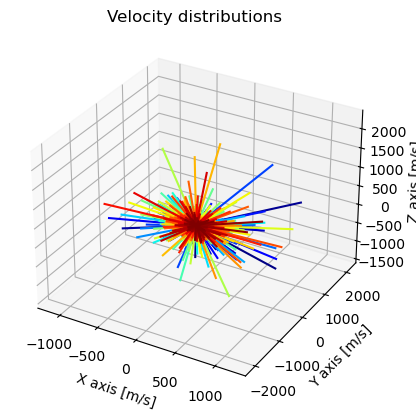

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plot the velocity vectors as lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N = len(v_vec)

for i in range(N):
    color = plt.cm.jet(i / N)  # Change color for each line
    ax.plot([0, v_vec[i, 0]], [0, v_vec[i, 1]], [0, v_vec[i, 2]], color=color)

ax.set_title("Velocity distributions")
ax.set_xlabel('X axis [m/s]')
ax.set_ylabel('Y axis [m/s]')
ax.set_zlabel('Z axis [m/s]')
plt.show()

# Save the plot in high quality
# fig.savefig('plot/velocity_distribution.png', dpi=800)

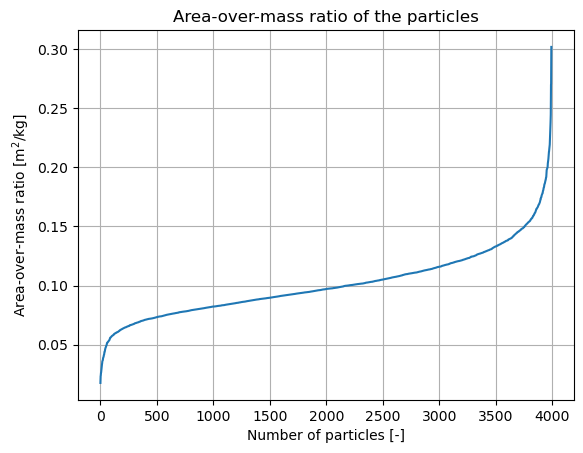

In [19]:
plt.plot(sorted(Am))
plt.title('Area-over-mass ratio of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel(r'Area-over-mass ratio [m$^2$/kg]')
plt.grid('on')

# # Save the plot in high quality
# plt.savefig('plot/AOM.png', dpi=800)
plt.show()

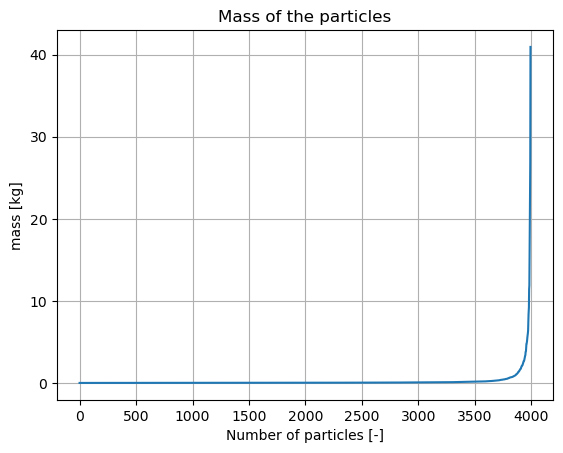

In [20]:
plt.plot(sorted(m))
plt.title('Mass of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel('mass [kg]')
plt.grid('on')
# # Save the plot in high quality
# plt.savefig('plot/m.png', dpi=800)
plt.show()

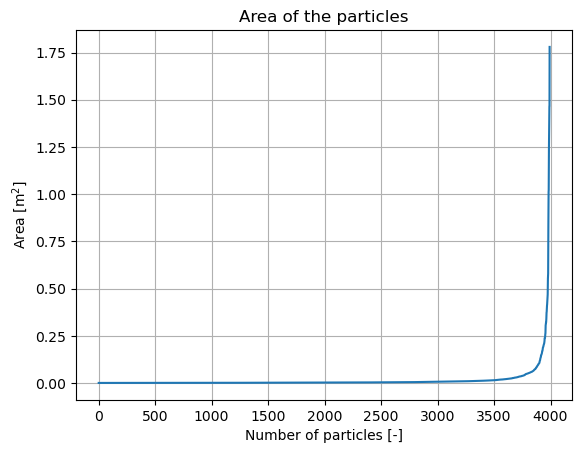

In [21]:
plt.plot(sorted(A))
plt.title('Area of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel(r'Area [m$^2$]')
plt.grid('on')
# # Save the plot in high quality
# plt.savefig('plot/A.png', dpi=800)
plt.show()

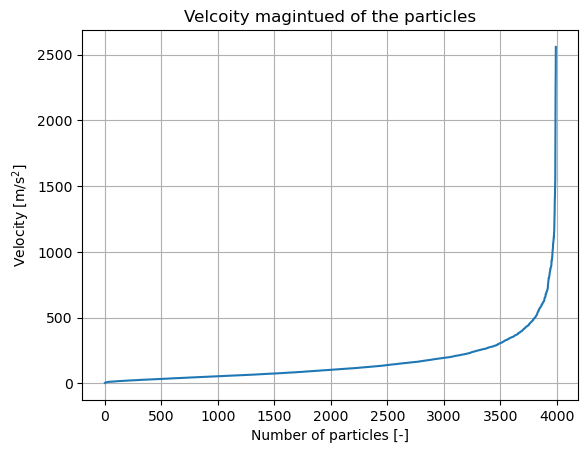

In [22]:
plt.plot(sorted(dv))
plt.title('Velcoity magintued of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel(r'Velocity [m/s$^2$]')
plt.grid('on')
# # Save the plot in high quality
# plt.savefig('plot/v.png', dpi=800)
plt.show()

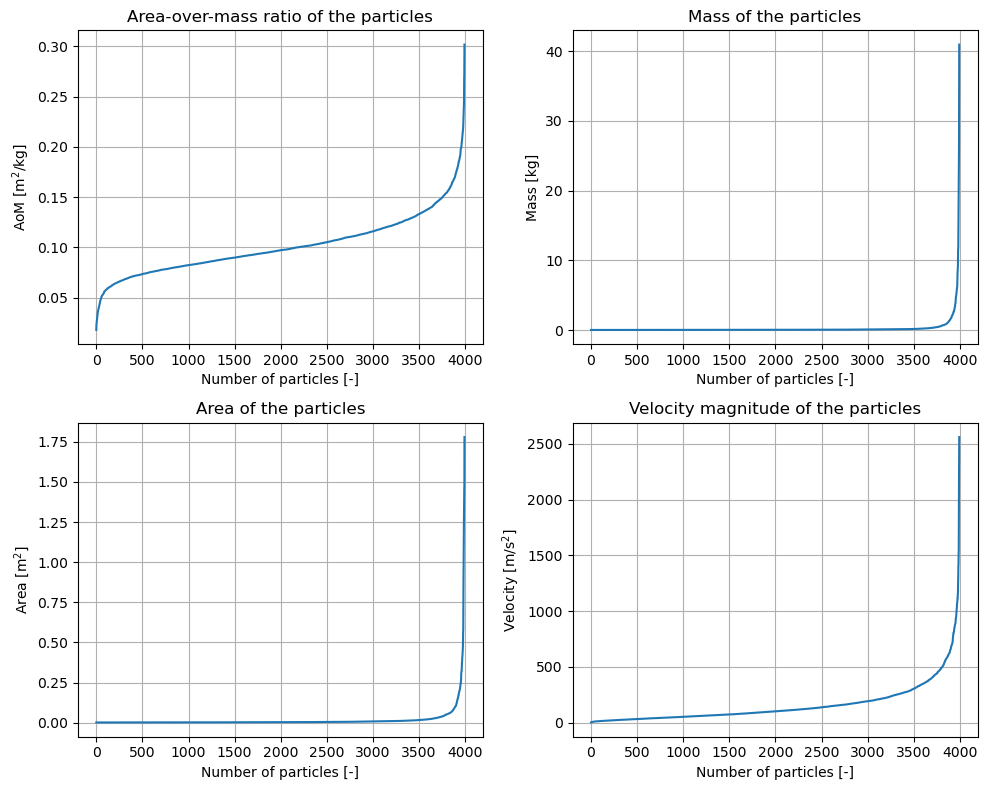

In [23]:
import matplotlib.pyplot as plt

# Assuming Am, m, A, and dv are your data arrays

# Set the figure size
fig = plt.figure(figsize=(10, 8))

# Create a 2x2 subplot grid
plt.subplot(2, 2, 1)
plt.plot(sorted(Am))
plt.title('Area-over-mass ratio of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel(r'AoM [m$^2$/kg]')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(sorted(m))
plt.title('Mass of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel('Mass [kg]')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(sorted(A))
plt.title('Area of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel(r'Area [m$^2$]')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(sorted(dv))
plt.title('Velocity magnitude of the particles')
plt.xlabel('Number of particles [-]')
plt.ylabel(r'Velocity [m/s$^2$]')
plt.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# # Save the plot in high quality
# plt.savefig('plot/subplot.png', dpi=800)

# Show the plots
plt.show()

Finally we save the vectors we need to generate the new population

In [ ]:
# saving the vector of the radius and of the velocity of the particles
# with open("breakup.pk", "wb") as file:
#     pkl.dump((d, v_vec), file)